# Target

1. Use Global Average Pooling (GAP) to convert 2D to 1D inputs. 

2. Also, increase the capacity of the network (while keeping model size reasonable, less than 10k) in order to improve training as well as test accuracy. 

3. Finally, get rid of the big 5X5 kernel at the end & set bias as False in the Convolution Layers. 

# Results

Total Parameters: 9910

Best Training Accuracy: 98.96

Best Test Accuracy: 99.41

# Analysis

1. Model has attained test acuracy of 99.40 there may be scope for improvement.   

2. We can improve the test accuracy (reduce mis-classifications) by using Image Augmentation.  

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       #transforms.RandomErasing(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 12, kernel_size=3, padding=0), # RF 3
            BatchNorm2d(12),           
            ReLU(inplace=True),
            nn.Dropout(0.1),            

            Conv2d(12, 12, kernel_size=3, padding=0), # RF 5
            BatchNorm2d(12),             
            ReLU(inplace=True),
            nn.Dropout(0.1),            

            Conv2d(12, 16, kernel_size=3, padding=0), # RF 7
            BatchNorm2d(16),             
            ReLU(inplace=True),
            nn.Dropout(0.1),                  

            MaxPool2d(kernel_size=2), # RF 8
            
            # Conv2d(16, 14, kernel_size=1, padding=0),
            # BatchNorm2d(14),             
            # ReLU(inplace=True),
            # nn.Dropout(0.1),            

            Conv2d(16, 16, kernel_size=3, padding=0), # RF 12
            BatchNorm2d(16),             
            ReLU(inplace=True),
            nn.Dropout(0.1),            
            
            Conv2d(16, 12, kernel_size=3, padding=0), # RF 16
            BatchNorm2d(12),             
            ReLU(inplace=True),
            nn.Dropout(0.1),

            Conv2d(12, 12, kernel_size=3, padding=0), # RF 20
            BatchNorm2d(12),             
            ReLU(inplace=True),
            nn.Dropout(0.1),            

            Conv2d(12, 10, kernel_size=3, padding=0), # RF 24
            BatchNorm2d(10),             
            ReLU(inplace=True),
            nn.Dropout(0.1),

            nn.AdaptiveAvgPool2d((1,1)), # RF 28
            Conv2d(10, 10, kernel_size=1, bias = False) # RF 28

        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [30]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,308
       BatchNorm2d-6           [-1, 12, 24, 24]              24
              ReLU-7           [-1, 12, 24, 24]               0
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,744
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14             [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [32]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.13508404791355133 Batch_id=468 Accuracy=82.96: 100%|██████████| 469/469 [00:12<00:00, 36.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0733, Accuracy: 9820/10000 (98.20%)

EPOCH: 1


Loss=0.0714954286813736 Batch_id=468 Accuracy=96.96: 100%|██████████| 469/469 [00:12<00:00, 36.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9876/10000 (98.76%)

EPOCH: 2


Loss=0.060038354247808456 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:12<00:00, 36.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9885/10000 (98.85%)

EPOCH: 3


Loss=0.10649532079696655 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:12<00:00, 37.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.04218936339020729 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:12<00:00, 37.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.03595675155520439 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:12<00:00, 37.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Loss=0.09910871833562851 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:12<00:00, 37.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.03668835014104843 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:12<00:00, 37.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9934/10000 (99.34%)

EPOCH: 8


Loss=0.03026348352432251 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:12<00:00, 37.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.018121251836419106 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:12<00:00, 37.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.01701662503182888 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:12<00:00, 37.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.008374020457267761 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:12<00:00, 37.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.018329396843910217 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:12<00:00, 36.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.05100030079483986 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:12<00:00, 37.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.03163101151585579 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:12<00:00, 37.34it/s]



Test set: Average loss: 0.0223, Accuracy: 9940/10000 (99.40%)



Text(0.5, 1.0, 'Test Accuracy')

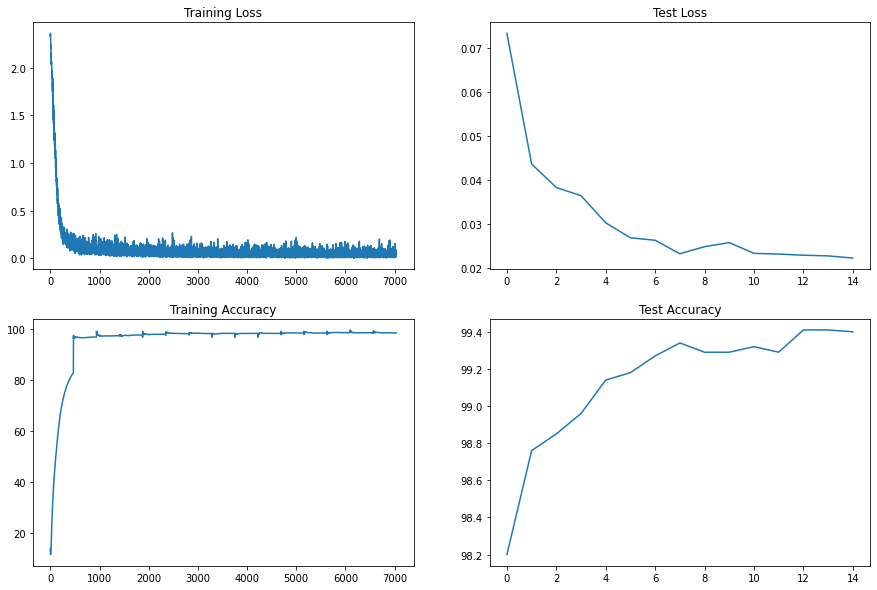

In [33]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")